In [1]:
from happytransformer import HappyTextToText

c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
W0629 21:13:05.747000 12588 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")

c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
06/29/2025 21:13:13 - INFO - happytransformer.happy_transformer -   Using device: cpu


In [3]:
from happytransformer import TTSettings

In [4]:
args = TTSettings(num_beams=5, min_length=1)

In [5]:
result = happy_tt.generate_text("grammar: This sentences has has bads grammar.", args=args)

06/29/2025 21:13:13 - INFO - happytransformer.happy_transformer -   Moving model to cpu
06/29/2025 21:13:13 - INFO - happytransformer.happy_transformer -   Initializing a pipeline


In [6]:
result.text

'This sentence has bad grammar.'

Load Pretrained Model

In [7]:
happy_tt = HappyTextToText("T5", "t5-base")

c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
06/29/2025 21:13:20 - INFO - happytransformer.happy_transformer -   Using device: cpu


Load Dataset (JFLEG)

In [8]:
from datasets import load_dataset

In [9]:
train_dataset = load_dataset("jfleg", split='validation[:]')

eval_dataset = load_dataset("jfleg", split='test[:]')

Data Inspection

In [10]:
# Data examination
print("🔍 Data Examination:")
for case in train_dataset["corrections"][:2]:
    print(case)
    print("First correction:", case[0])
    print("--------------------------------------------------------")

🔍 Data Examination:
['So I think we would not be alive if our ancestors did not develop sciences and technologies . ', 'So I think we could not live if older people did not develop science and technologies . ', 'So I think we can not live if old people could not find science and technologies and they did not develop . ', 'So I think we can not live if old people can not find the science and technology that has not been developed . ']
First correction: So I think we would not be alive if our ancestors did not develop sciences and technologies . 
--------------------------------------------------------
['Not for use with a car . ', 'Do not use in the car . ', 'Car not for use . ', 'Can not use the car . ']
First correction: Not for use with a car . 
--------------------------------------------------------


Convert Dataset to CSV

In [11]:
def generate_csv(csv_path, dataset):
    with open(csv_path, 'w', newline='') as csvfile:
        writter = csv.writer(csvfile)
        writter.writerow(["input", "target"])
        for case in dataset:
     	    # Adding the task's prefix to input 
            input_text = "grammar: " + case["sentence"]
            for correction in case["corrections"]:
                # a few of the cases contain blank strings. 
                if input_text and correction:
                    writter.writerow([input_text, correction])

In [12]:
import csv
generate_csv("train.csv", train_dataset)
generate_csv("eval.csv", eval_dataset)

Evaluate Before Fine-Tuning

In [ ]:
before_result = happy_tt.eval("eval.csv")

06/29/2025 21:13:48 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...


Generating eval split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2988 [00:00<?, ? examples/s]

c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/2988 [00:00<?, ?it/s]

In [ ]:
print("Before loss:", before_result.loss)

Before loss: 1.2803850173950195


Fine-Tuning the Model

In [15]:
from happytransformer import TTTrainArgs    
args = TTTrainArgs(batch_size=8)
happy_tt.train("train.csv", args=args)

Generating train split: 0 examples [00:00, ? examples/s]

06/29/2025 21:31:05 - INFO - happytransformer.happy_transformer -   Tokenizing training data...


Map:   0%|          | 0/2714 [00:00<?, ? examples/s]

Map:   0%|          | 0/302 [00:00<?, ? examples/s]

06/29/2025 21:31:18 - INFO - happytransformer.happy_transformer -   Moving model to cpu


  0%|          | 0/340 [00:00<?, ?it/s]

c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 1.6535, 'learning_rate': 4.985294117647059e-05, 'epoch': 0.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 1.13018798828125, 'eval_runtime': 58.5581, 'eval_samples_per_second': 5.157, 'eval_steps_per_second': 0.649, 'epoch': 0.0}
{'loss': 0.8249, 'learning_rate': 4.5e-05, 'epoch': 0.1}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.6655476093292236, 'eval_runtime': 107.2838, 'eval_samples_per_second': 2.815, 'eval_steps_per_second': 0.354, 'epoch': 0.1}
{'loss': 0.7024, 'learning_rate': 4e-05, 'epoch': 0.2}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.5884343981742859, 'eval_runtime': 105.5301, 'eval_samples_per_second': 2.862, 'eval_steps_per_second': 0.36, 'epoch': 0.2}
{'loss': 0.6765, 'learning_rate': 3.5e-05, 'epoch': 0.3}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.553026020526886, 'eval_runtime': 89.8588, 'eval_samples_per_second': 3.361, 'eval_steps_per_second': 0.423, 'epoch': 0.3}
{'loss': 0.6083, 'learning_rate': 3e-05, 'epoch': 0.4}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.5329804420471191, 'eval_runtime': 50.2395, 'eval_samples_per_second': 6.011, 'eval_steps_per_second': 0.756, 'epoch': 0.4}
{'loss': 0.6418, 'learning_rate': 2.5e-05, 'epoch': 0.5}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.5162224173545837, 'eval_runtime': 63.7319, 'eval_samples_per_second': 4.739, 'eval_steps_per_second': 0.596, 'epoch': 0.5}
{'loss': 0.572, 'learning_rate': 2e-05, 'epoch': 0.6}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.5141406059265137, 'eval_runtime': 61.8356, 'eval_samples_per_second': 4.884, 'eval_steps_per_second': 0.615, 'epoch': 0.6}
{'loss': 0.6071, 'learning_rate': 1.5e-05, 'epoch': 0.7}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.5015975832939148, 'eval_runtime': 59.4427, 'eval_samples_per_second': 5.081, 'eval_steps_per_second': 0.639, 'epoch': 0.7}
{'loss': 0.5839, 'learning_rate': 1e-05, 'epoch': 0.8}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.5005519986152649, 'eval_runtime': 50.0543, 'eval_samples_per_second': 6.033, 'eval_steps_per_second': 0.759, 'epoch': 0.8}
{'loss': 0.6643, 'learning_rate': 5e-06, 'epoch': 0.9}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.496602863073349, 'eval_runtime': 67.5307, 'eval_samples_per_second': 4.472, 'eval_steps_per_second': 0.563, 'epoch': 0.9}
{'loss': 0.5681, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.49586179852485657, 'eval_runtime': 67.4371, 'eval_samples_per_second': 4.478, 'eval_steps_per_second': 0.563, 'epoch': 1.0}
{'train_runtime': 3561.6725, 'train_samples_per_second': 0.762, 'train_steps_per_second': 0.095, 'train_loss': 0.6473767073715434, 'epoch': 1.0}


In [16]:
args = TTTrainArgs(batch_size=8)
happy_tt.train("train.csv", args=args)

06/29/2025 22:30:43 - INFO - happytransformer.happy_transformer -   Tokenizing training data...


Map:   0%|          | 0/2714 [00:00<?, ? examples/s]

Map:   0%|          | 0/302 [00:00<?, ? examples/s]

  0%|          | 0/340 [00:00<?, ?it/s]

{'loss': 0.5921, 'learning_rate': 4.985294117647059e-05, 'epoch': 0.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.49561911821365356, 'eval_runtime': 53.7368, 'eval_samples_per_second': 5.62, 'eval_steps_per_second': 0.707, 'epoch': 0.0}
{'loss': 0.3668, 'learning_rate': 4.5e-05, 'epoch': 0.1}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.518059492111206, 'eval_runtime': 61.7616, 'eval_samples_per_second': 4.89, 'eval_steps_per_second': 0.615, 'epoch': 0.1}
{'loss': 0.3785, 'learning_rate': 4e-05, 'epoch': 0.2}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.5236842632293701, 'eval_runtime': 51.6246, 'eval_samples_per_second': 5.85, 'eval_steps_per_second': 0.736, 'epoch': 0.2}
{'loss': 0.3879, 'learning_rate': 3.5e-05, 'epoch': 0.3}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.511130154132843, 'eval_runtime': 57.1016, 'eval_samples_per_second': 5.289, 'eval_steps_per_second': 0.665, 'epoch': 0.3}
{'loss': 0.3619, 'learning_rate': 3e-05, 'epoch': 0.4}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.5118660926818848, 'eval_runtime': 52.7111, 'eval_samples_per_second': 5.729, 'eval_steps_per_second': 0.721, 'epoch': 0.4}
{'loss': 0.4043, 'learning_rate': 2.5e-05, 'epoch': 0.5}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.5028151273727417, 'eval_runtime': 52.5313, 'eval_samples_per_second': 5.749, 'eval_steps_per_second': 0.723, 'epoch': 0.5}
{'loss': 0.3842, 'learning_rate': 2e-05, 'epoch': 0.6}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.5024142861366272, 'eval_runtime': 52.1985, 'eval_samples_per_second': 5.786, 'eval_steps_per_second': 0.728, 'epoch': 0.6}
{'loss': 0.4554, 'learning_rate': 1.5e-05, 'epoch': 0.7}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.4895854890346527, 'eval_runtime': 57.6755, 'eval_samples_per_second': 5.236, 'eval_steps_per_second': 0.659, 'epoch': 0.7}
{'loss': 0.4675, 'learning_rate': 1e-05, 'epoch': 0.8}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.4879726469516754, 'eval_runtime': 51.0467, 'eval_samples_per_second': 5.916, 'eval_steps_per_second': 0.744, 'epoch': 0.8}
{'loss': 0.591, 'learning_rate': 5e-06, 'epoch': 0.9}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.48013296723365784, 'eval_runtime': 47.6511, 'eval_samples_per_second': 6.338, 'eval_steps_per_second': 0.797, 'epoch': 0.9}
{'loss': 0.5329, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.4783158004283905, 'eval_runtime': 119.9387, 'eval_samples_per_second': 2.518, 'eval_steps_per_second': 0.317, 'epoch': 1.0}
{'train_runtime': 2738.7277, 'train_samples_per_second': 0.991, 'train_steps_per_second': 0.124, 'train_loss': 0.43369211799958174, 'epoch': 1.0}


In [17]:
beam_settings =  TTSettings(num_beams=5, min_length=1, max_length=20)

Save the Fine-Tuned Model

In [18]:
happy_tt.save("saved_model/")


In [ ]:
""" Contoh: """
example_1 = "grammar: I are eating an apple."
result_1 = happy_tt.generate_text(example_1, args=beam_settings)
print(result_1.text) 

I am eating an apple.


Evaluation using HuggingFace evaluate

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


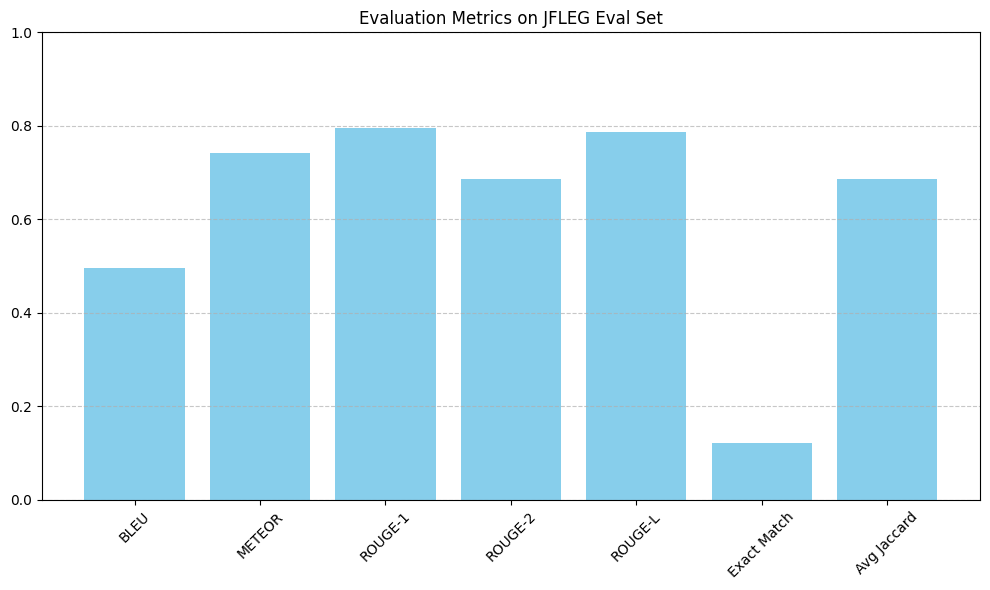

BLEU: 0.4968
METEOR: 0.7423
ROUGE-1: 0.7945
ROUGE-2: 0.6856
ROUGE-L: 0.7862
Exact Match: 0.1217
Avg Jaccard: 0.6863


In [25]:
from evaluate import load
import matplotlib.pyplot as plt
import numpy as np

# Load evaluator dari HuggingFace Evaluate
bleu = load("bleu")
meteor = load("meteor")
rouge = load("rouge")

# Inisialisasi list
references = []
predictions = []

prefix = "grammar: "

# Inference dan ambil satu ground-truth
for sample in eval_dataset:
    input_text = prefix + sample["sentence"]
    result = happy_tt.generate_text(input_text, args=beam_settings)
    prediction = result.text.strip()
    target = sample["corrections"][0].strip()

    predictions.append(prediction)
    references.append(target)

# Compute BLEU, METEOR, ROUGE
bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
meteor_score = meteor.compute(predictions=predictions, references=references)
rouge_score = rouge.compute(predictions=predictions, references=references)

# Exact Match
exact_match = np.mean([pred == ref for pred, ref in zip(predictions, references)])

# Jaccard Similarity (opsional sebagai tambahan analisis token-level)
def jaccard_similarity(a, b):
    a_tokens = set(a.split())
    b_tokens = set(b.split())
    intersection = a_tokens & b_tokens
    union = a_tokens | b_tokens
    return len(intersection) / len(union) if union else 0

jaccard_scores = [jaccard_similarity(pred, ref) for pred, ref in zip(predictions, references)]
avg_jaccard = np.mean(jaccard_scores)

# Simpan metrik
metrics = {
    "BLEU": bleu_score["bleu"],
    "METEOR": meteor_score["meteor"],
    "ROUGE-1": rouge_score["rouge1"],
    "ROUGE-2": rouge_score["rouge2"],
    "ROUGE-L": rouge_score["rougeL"],
    "Exact Match": exact_match,
    "Avg Jaccard": avg_jaccard
}

# Visualisasi
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.title("Evaluation Metrics on JFLEG Eval Set")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Cetak metrik
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")
